# Project 1 – Scene Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls

drive  sample_data


### Preprocessing Image Data (Normalization & Augmentation)

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [1]:
BATCH_SIZE = 100

# flow_from_directory() takes the path to a directory & generates batches of augmented data.

traingen = train_generator.flow_from_directory('/content/drive/My Drive/Vision System/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('/content/drive/My Drive/Vision System/valid',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

NameError: name 'train_generator' is not defined

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

### Experiment 1: 4 CNN layers, no dropout

In [26]:
model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                  

In [6]:
!pip install livelossplot

In [19]:
!nvidia-smi

Wed Nov 10 05:02:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    72W / 149W |  10598MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

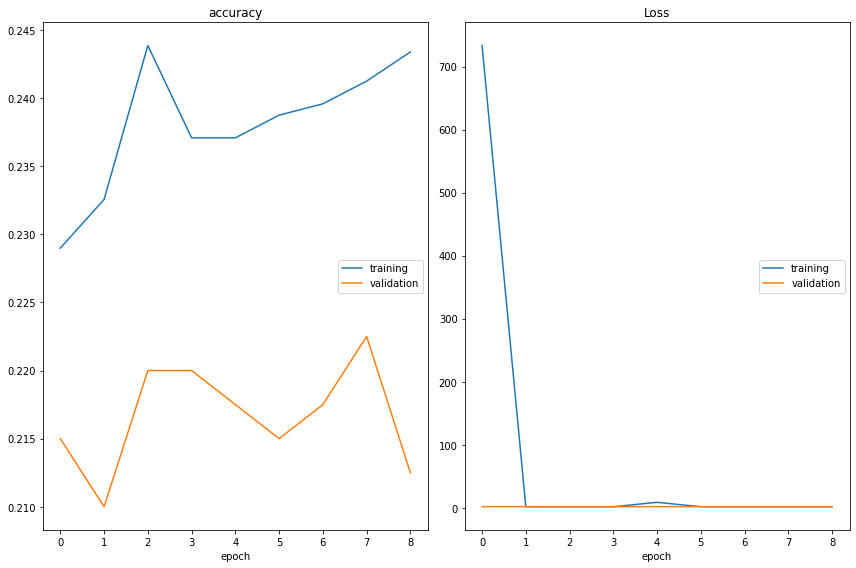

accuracy
	training         	 (min:    0.229, max:    0.244, cur:    0.243)
	validation       	 (min:    0.210, max:    0.222, cur:    0.213)
Loss
	training         	 (min:    1.564, max:  733.629, cur:    1.564)
	validation       	 (min:    1.650, max:    1.726, cur:    1.662)


In [27]:

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Very low accuracy probably because of huge dataset and low number of CNN layers to handle the features
2. Model is in underfitting stage
3. Loss is higher on both that confirms that model is making bad prediction 

### Experiment 2: 4 CNN layers, dropout=0.2, Adding batchnorm¶

In [15]:
from keras.layers import BatchNormalization

model1 = Sequential()

#### Input Layer ####
model1.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2)))  # Pooling
model1.add(Dropout(0.2)) # Dropout

model1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.2))

#### Fully-Connected Layer ####
model1.add(Flatten())
model1.add(Dense(5, activation='softmax'))

model1.summary() # a handy way to inspect the architecture

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)       

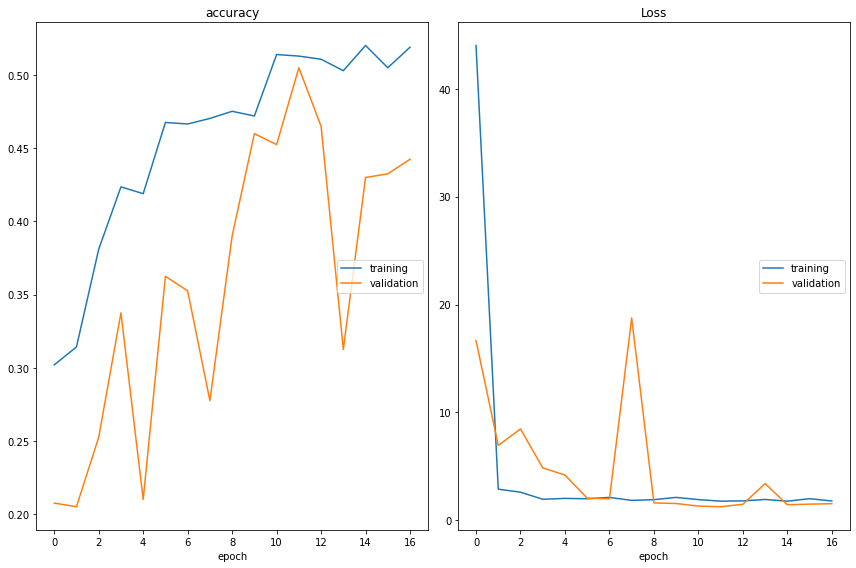

accuracy
	training         	 (min:    0.302, max:    0.520, cur:    0.519)
	validation       	 (min:    0.205, max:    0.505, cur:    0.442)
Loss
	training         	 (min:    1.774, max:   44.013, cur:    1.794)
	validation       	 (min:    1.259, max:   18.757, cur:    1.540)


In [17]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.01)

model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model1.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Model showed significant improvement with batch normalization and dropouts
2. But still Model is in underfitting stage though improved from earlier
3. But still Loss is higher on both that confirms that model is making bad prediction

### Experiment 3: 4 CNN layers, dropout=0.2, add batchnorm, add glorot uniform ie Xavier uniform initialization


In [20]:
model3 = Sequential()

#### Input Layer ####
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3),kernel_initializer="glorot_uniform"))

#### Convolutional Layers ####
model3.add(Conv2D(32, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))  # Pooling
model3.add(Dropout(0.2)) # Dropout

model3.add(Conv2D(64, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model3.add(Conv2D(64, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(0.2))

#### Fully-Connected Layer ####
model3.add(Flatten())
model3.add(Dense(5, activation='softmax'))

model3.summary() # a handy way to inspect the architecture

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 61, 64)       

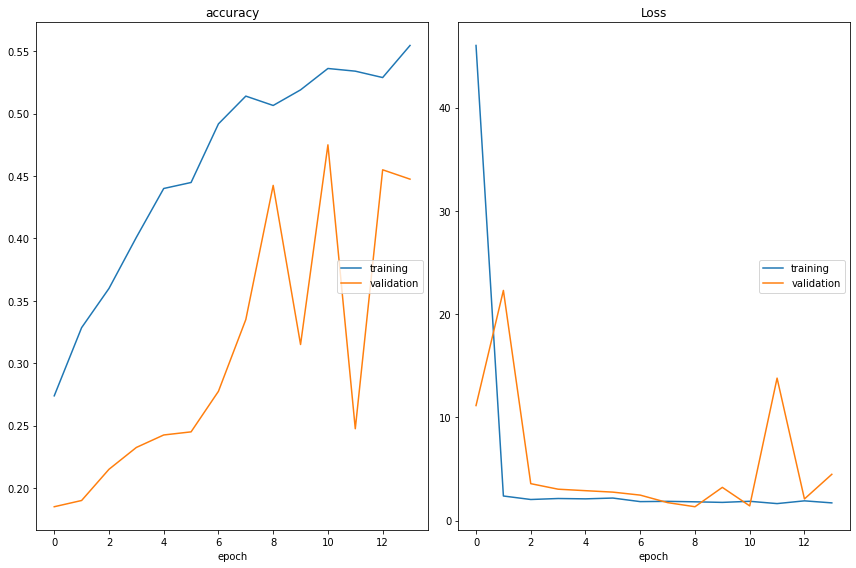

accuracy
	training         	 (min:    0.274, max:    0.555, cur:    0.555)
	validation       	 (min:    0.185, max:    0.475, cur:    0.447)
Loss
	training         	 (min:    1.655, max:   46.006, cur:    1.724)
	validation       	 (min:    1.351, max:   22.291, cur:    4.490)


In [21]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.01)

model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model3.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Model showed significant improvement with batch normalization and dropouts
2. But still Model is in underfitting stage though improved from earlier
3. But still Loss is higher on both that confirms that model is making bad prediction

### Experiment 4: Using high number of filters in each layer and increased learning rate

In [13]:
from keras.layers import BatchNormalization
model5 = Sequential()

#### Input Layer ####
model5.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3),kernel_initializer="glorot_uniform"))

#### Convolutional Layers ####
model5.add(Conv2D(64, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2,2)))  # Pooling
model5.add(Dropout(0.2)) # Dropout

model5.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model5.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(256, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(0.2))

#### Fully-Connected Layer ####
model5.add(Flatten())
model5.add(Dropout(0.2))
model5.add(Dense(5, activation='softmax'))

model5.summary() # a handy way to inspect the architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 63, 63, 128)      

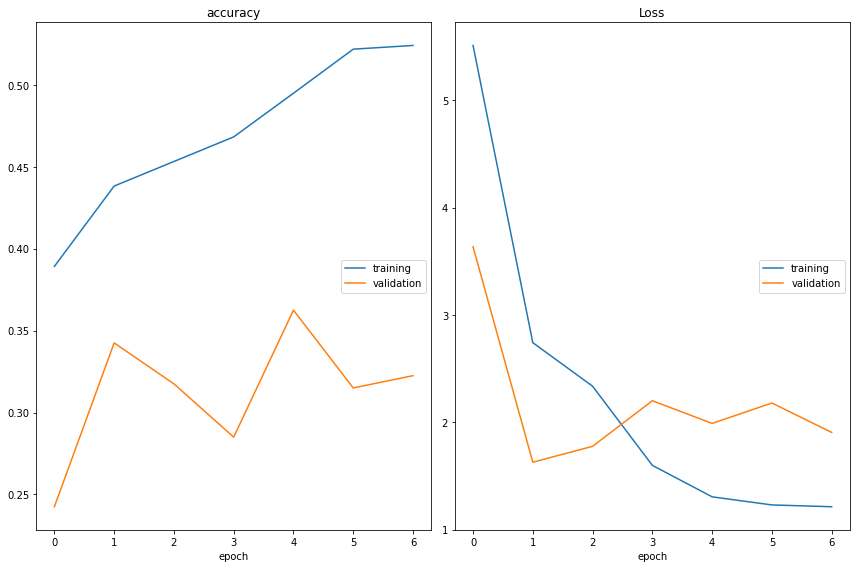

accuracy
	training         	 (min:    0.389, max:    0.524, cur:    0.524)
	validation       	 (min:    0.243, max:    0.363, cur:    0.322)
Loss
	training         	 (min:    1.214, max:    5.509, cur:    1.214)
	validation       	 (min:    1.628, max:    3.634, cur:    1.906)


In [20]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.001)

model5.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model5.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Model did not show any significant improvement with filters and learning rate
2. But still Model is in underfitting stage that is validation accuarcy is lower and loss is on higher side.
3. Number of epochs could be increase to see behaviour but computational cost is already on higher side

### Experiment 5: Iterating the above experiment with Changing the optimizer to Adam

In [32]:
model6 = Sequential()

#### Input Layer ####
model6.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3),kernel_initializer="glorot_uniform"))

#### Convolutional Layers ####
model6.add(Conv2D(64, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))  # Pooling
model6.add(Dropout(0.2)) # Dropout

model6.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model6.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(256, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))
model6.add(Dropout(0.2))

#### Fully-Connected Layer ####
model6.add(Flatten())
model6.add(Dropout(0.2))
model6.add(Dense(5, activation='softmax'))

model6.summary() # a handy way to inspect the architecture

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 126, 126, 64)      36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 63, 63, 128)       73856     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 61, 61, 128)      

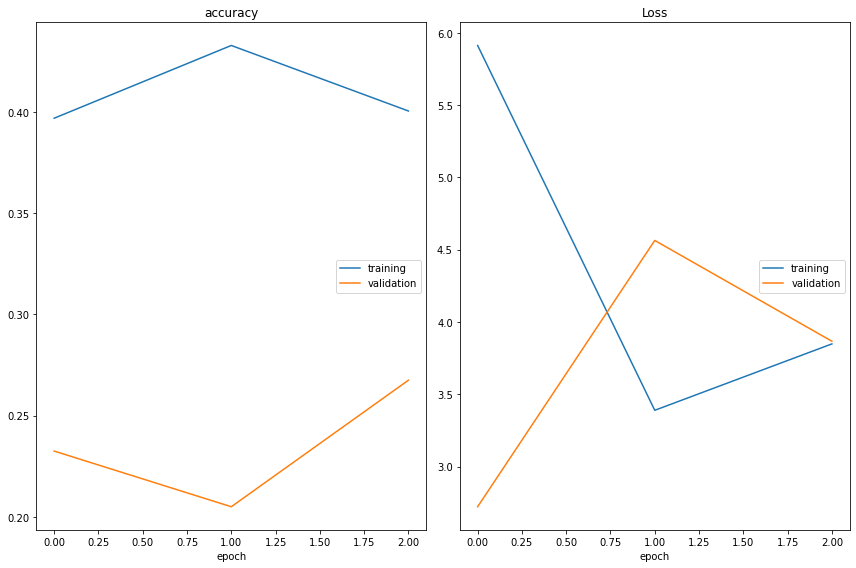

accuracy
	training         	 (min:    0.397, max:    0.433, cur:    0.400)
	validation       	 (min:    0.205, max:    0.268, cur:    0.268)
Loss
	training         	 (min:    3.389, max:    5.913, cur:    3.848)
	validation       	 (min:    2.722, max:    4.564, cur:    3.867)


KeyboardInterrupt: ignored

In [34]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = Adam(learning_rate=0.001)

model6.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model6.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Adam optimizer dosent seem to working, it is not able to handle noise in dataset 
3. Model performed worst and had to be stopped

In [36]:
from tensorflow.keras.optimizers import Nadam


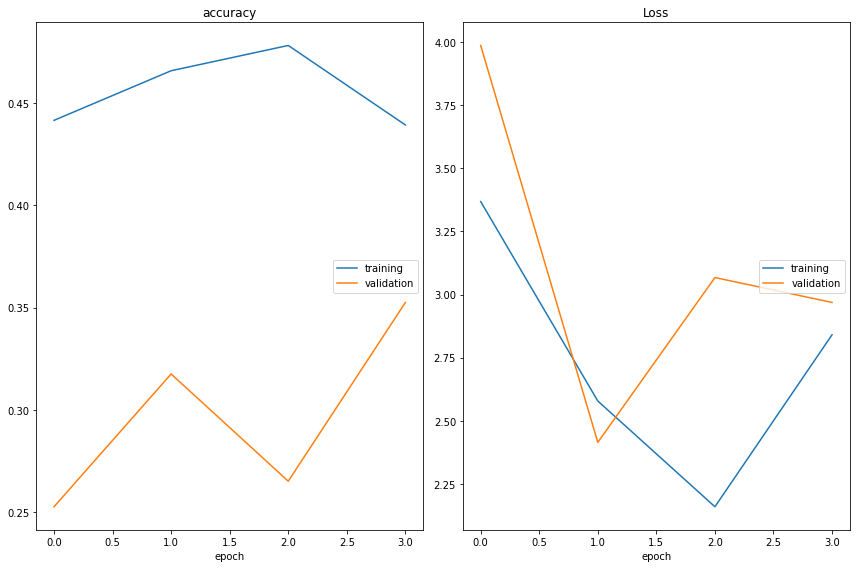

accuracy
	training         	 (min:    0.439, max:    0.478, cur:    0.439)
	validation       	 (min:    0.252, max:    0.352, cur:    0.352)
Loss
	training         	 (min:    2.159, max:    3.368, cur:    2.840)
	validation       	 (min:    2.414, max:    3.986, cur:    2.969)


KeyboardInterrupt: ignored

In [37]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = Nadam(learning_rate=0.001)

model6.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model6.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. Nadam optimizer dosent seem to working, it is not able to handle noise in dataset 
3. Model performed worst and had to be stopped

In [38]:
model7 = Sequential()

#### Input Layer ####
model7.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3),kernel_initializer="glorot_uniform"))

#### Convolutional Layers ####
model7.add(Conv2D(64, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))  # Pooling
model7.add(Dropout(0.4)) # Dropout

model7.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

model7.add(Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Conv2D(128, (3,3), activation='relu',kernel_initializer="glorot_uniform"))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

model7.add(Conv2D(256, (3,3), padding='same', activation='relu',kernel_initializer="glorot_uniform"))
model7.add(Activation('relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.4))

#### Fully-Connected Layer ####
model7.add(Flatten())
model7.add(Dropout(0.4))
model7.add(Dense(5, activation='softmax'))

model7.summary() # a handy way to inspect the architecture

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 126, 126, 64)      36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 63, 63, 128)       73856     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 61, 61, 128)     

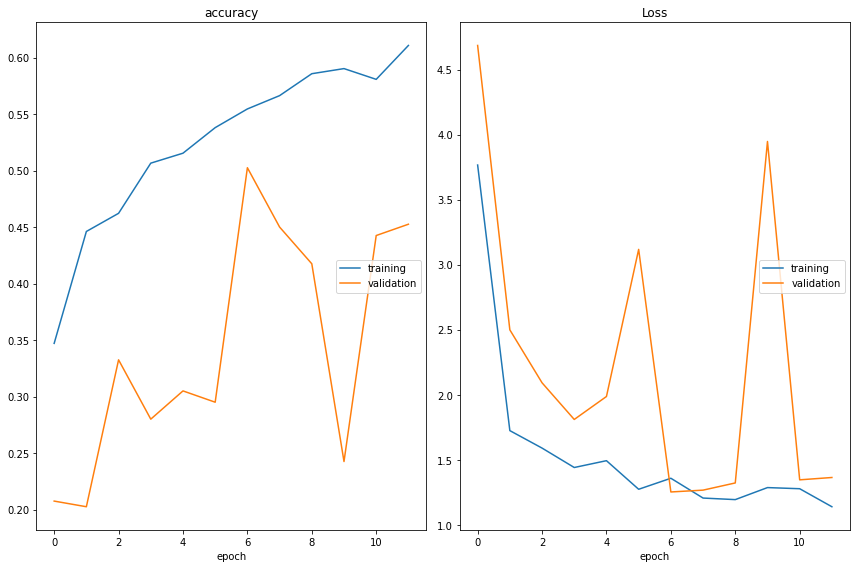

accuracy
	training         	 (min:    0.347, max:    0.611, cur:    0.611)
	validation       	 (min:    0.203, max:    0.502, cur:    0.452)
Loss
	training         	 (min:    1.139, max:    3.766, cur:    1.139)
	validation       	 (min:    1.252, max:    4.685, cur:    1.364)


In [39]:
steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.001)

model7.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model7.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

Observations:-

1. With more layer and filters model improved on perfromance
2. Validation accuracy is not following training that means model is still underfitting stage
3. Validation loss is also have high fluctions making model unstable to new data
4. Overall, model has perfromed better than all other models

### Evaluating the Network

In [22]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/drive/My Drive/Vision System/valid',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)


Found 2830 images belonging to 5 classes.


In [46]:
model.load_weights('img_model.weights.best.hdf5')

predicted_classes = model.predict(testgen).argmax(axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

### Visualizing the Results

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [48]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 21.45%


,Precision,Recall,F-Score,Support
3,0.214488,1.0,0.353215,607.0
0,0.000000,0.0,0.000000,526.0
1,0.000000,0.0,0.000000,549.0
2,0.000000,0.0,0.000000,591.0
4,0.000000,0.0,0.000000,557.0


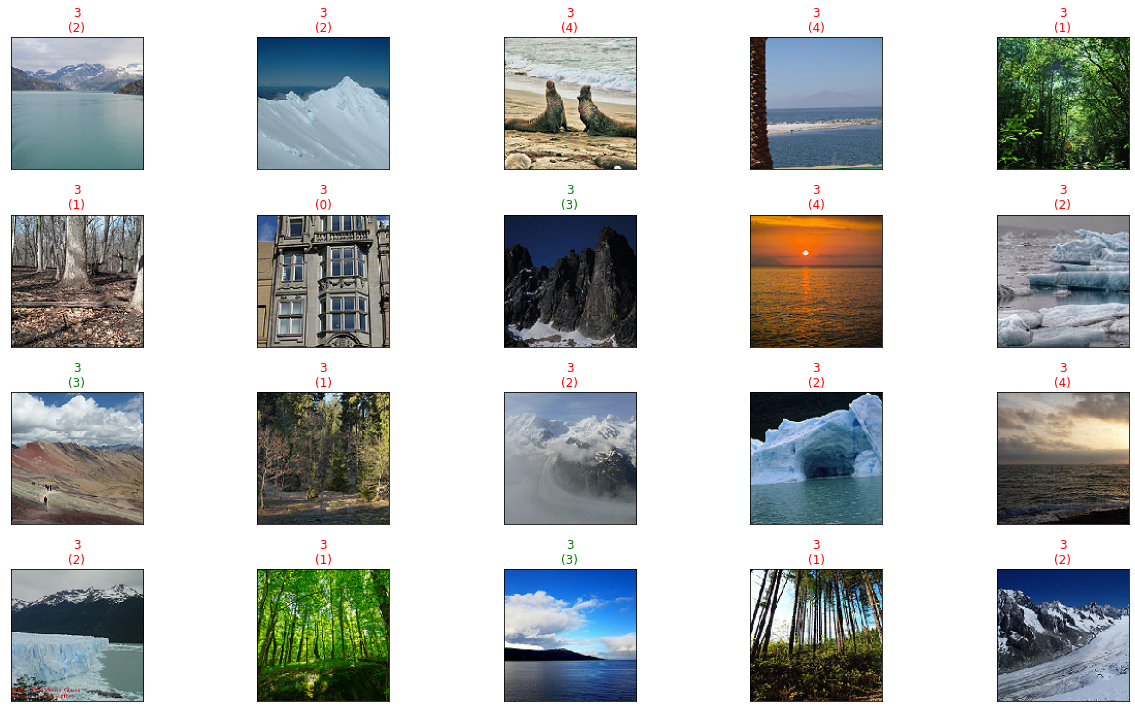

In [49]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)